In [ ]:
#importing necessary libraries
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
#Download dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')


# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:   
    tar.extractall(path='./data')


data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['train', 'test']
['bird', 'frog', 'deer', 'dog', 'cat', 'truck', 'ship', 'airplane', 'automobile', 'horse']


In [ ]:
files = os.listdir(data_dir+"/train/airplane")
print(len(files))

5000


In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])



In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
print(train_ds.classes)  #classes is a property of dataset returning an array of classes

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
img, label = train_ds[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[ 1.7968,  1.7581,  1.7193,  ...,  1.7968,  1.7775,  1.7387],
         [ 1.6999,  1.6805,  1.6418,  ...,  1.6999,  1.6805,  1.6612],
         [ 1.6224,  1.6030,  1.5836,  ...,  1.6418,  1.6224,  1.6030],
         ...,
         [ 2.4365,  2.3978,  2.3396,  ..., -1.2466, -1.1690, -1.1109],
         [ 2.2039,  2.3009,  2.3009,  ..., -1.2466, -1.1884, -1.0140],
         [ 2.1458,  2.2427,  2.2815,  ..., -1.2660, -0.8977, -0.1998]],

        [[ 1.8888,  1.8298,  1.7904,  ...,  1.9085,  1.8888,  1.8495],
         [ 1.7904,  1.7708,  1.7314,  ...,  1.8101,  1.7904,  1.7708],
         [ 1.7118,  1.6921,  1.6724,  ...,  1.7511,  1.7314,  1.7118],
         ...,
         [ 2.4591,  2.4198,  2.3805,  ..., -1.2579, -1.1989, -1.1399],
         [ 2.2428,  2.3215,  2.3608,  ..., -1.2382, -1.1989, -1.0219],
         [ 2.2035,  2.3018,  2.3411,  ..., -1.1989, -0.8449, -0.1172]],

        [[ 1.9538,  1.9148,  1.8758,  ...,  2.0123,  1.9928,  1.9733],
         [ 1.8367,  1.8172,  1.7782,  ...,  1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  airplane (0)


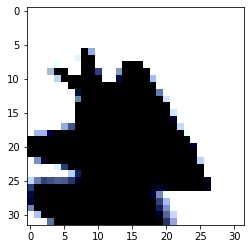

In [ ]:
# to see image

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))           #we have to permute the image shape as plt take dimensions in that way

show_example(*train_ds[0])         #used *args_star to pass its multiple parameters

random_seed = 42
torch.manual_seed(random_seed);       #we can fix any number here so we get same random set whenever we restart this module

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

#we use this num_workers to get all otherthreads to download  data fastly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


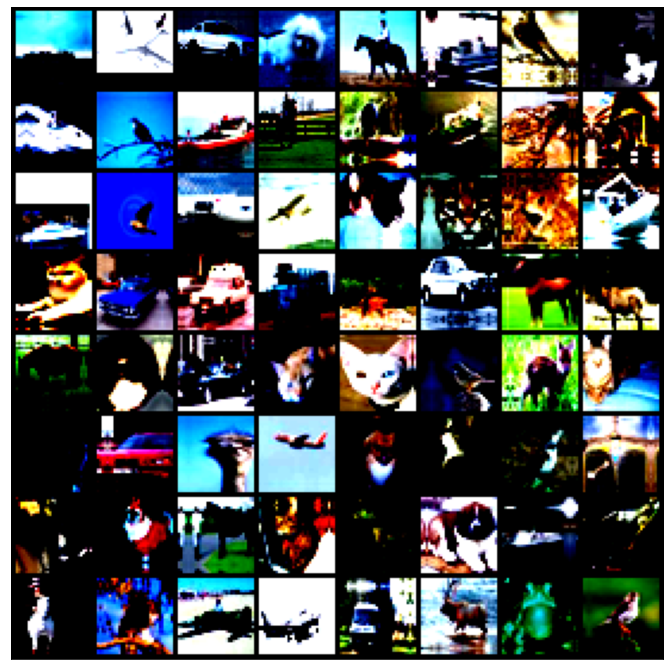

In [ ]:
from torchvision.utils import make_grid   #to combine lot of images together

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))     #nrow represent no of images in a row
        break

show_batch(train_dl)

In [ ]:
#from now onwards this can be used as a base class

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
#and then extend our base class for our model
#we use nn.Sequential to chain the layers and activation functions into a single network architecture

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = ResNet9(3,10)
model       #it expains about all layers and fnc in our model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

**Now we enable gpu in our model for fast processing.**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')                  #picks gpu if it is there else cpu 
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device                                  #we have to change our runtime to gpu before start working on notebook

device(type='cuda')

In [ ]:
#to train our model

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)           #to pass data from cpu to gpu memory

In [ ]:
model = to_device(ResNet9(3,10), device)   
evaluate(model, valid_dl)                           #as kernels have also random data our initial val_acc is approx 10%

{'val_acc': 0.08388672024011612, 'val_loss': 2.304614782333374}

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 1.2808, val_loss: 1.0638, val_acc: 0.6417
Epoch [1], train_loss: 1.0153, val_loss: 1.1637, val_acc: 0.6025
Epoch [2], train_loss: 0.7718, val_loss: 0.8316, val_acc: 0.7311
Epoch [3], train_loss: 0.6049, val_loss: 0.6448, val_acc: 0.7841
Epoch [4], train_loss: 0.5271, val_loss: 0.5002, val_acc: 0.8258
Epoch [5], train_loss: 0.4295, val_loss: 0.4008, val_acc: 0.8585
Epoch [6], train_loss: 0.3130, val_loss: 0.2949, val_acc: 0.8978
Epoch [7], train_loss: 0.2062, val_loss: 0.2666, val_acc: 0.9108


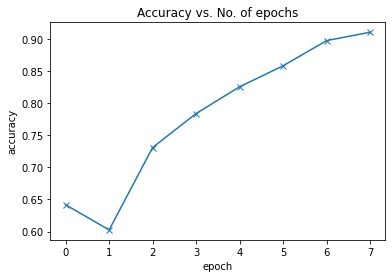

In [ ]:
# as we can see that acc starts decrasing because of overfitting 
#plotting

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

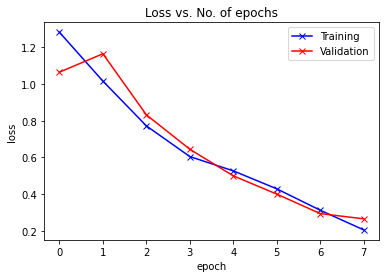

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

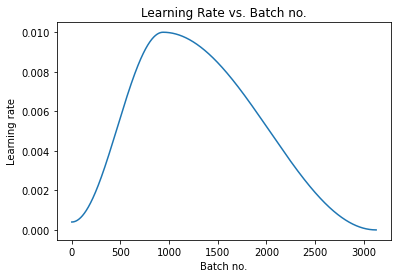

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

In [ ]:
#testing with few images

test_dataset = ImageFolder(data_dir+'/test', transform=tt.ToTensor())

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]



Label: airplane , Predicted: airplane


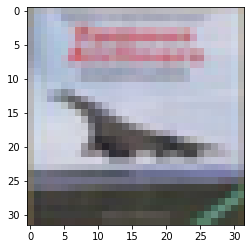

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


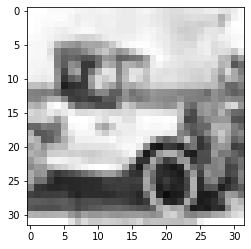

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))